## Classifier: this model will be responsible for predicting the status of persons if they have low/high stress.

### Dataset: https://www.kaggle.com/datasets/ziya07/mental-health-monitor-using-wearable-iot-sensors/data

What we have in dataset:

    - EEG Frequency Bands: The values of different EEG frequency bands (delta, theta, alpha, beta) that reflect brain activity.
    - GSR Values: Electrodermal activity representing emotional arousal or stress levels.
    - Cognitive State: The state of the individual's cognitive engagement (Focused, Distracted, or Cognitive Overload).
    - Emotional State: The individual's emotional state, categorized as Calm, Anxious, or Stressed.
    - Student Demographics: Information about the student, including their ID, age, gender, and the session type (study, test, relaxation).
    - Session Duration: The duration of the session in minutes.
    - Environmental Context: The context of the environment (e.g., Quiet Room, Library, or Home).
    - Preprocessed Features: Features obtained after data preprocessing, such as ICA components and mean GSR values.
    - Target: A binary label (1: High Stress, 0: Low Stress) representing the target mental health condition for classification purposes.

    - Steps:
        - Handling dataset:
            - Remapping stringified features into binary reprasantation
            - Normalizing dataset [if necessary]
            - Splitting dataset into [%70 Training] [%20 Testing] [%10 Validation]
            - Convert dataset into tensor

### Model Architecture: [1D CNN] : we will use fully connected layers (Neural Network):
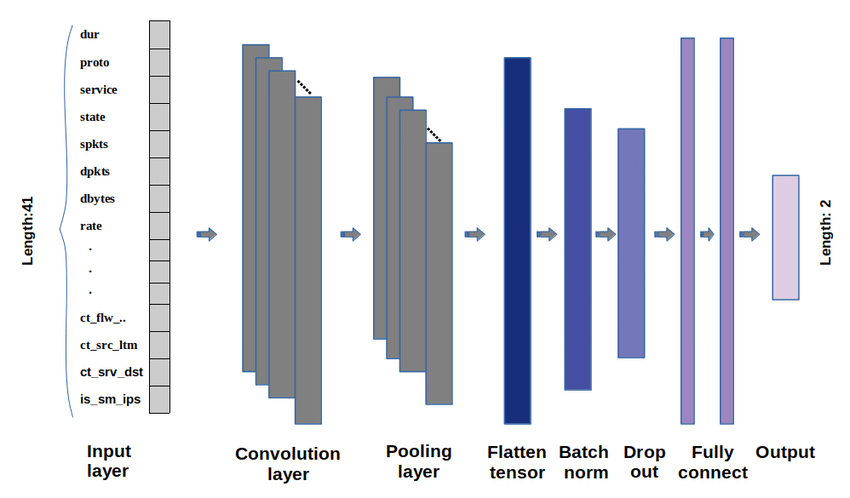

This architecture is inspired by the following paper:
(https://www.researchgate.net/figure/The-architecture-of-the-1D-CNN-simple-model-for-intrusion-detection-The-network-consists_fig1_340697891)
```
Input (GSR, EEG, HR ...)
   ↓
1D CNN (feature extraction)
   ↓
BatchNorm → ReLU → Dropout
   ↓
FullyConnecyedLayer → Softmax (32,1) -> Binary Classifer
```

##### Optimizer: SDG,
##### Loss Function: Binary Classification With Logits
##### Accuracy Function ```correct_ypreds / y_true * 100```

##### Training Loop: training step + validation step
##### Testing Model
##### Store the model into pth file
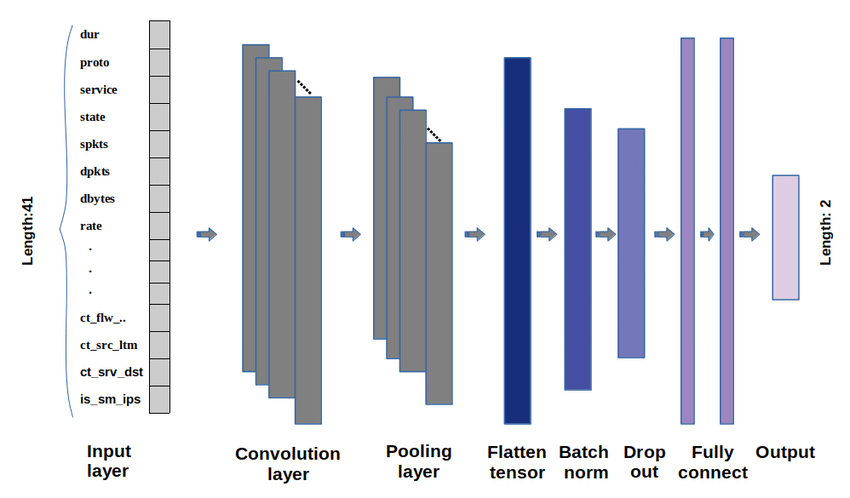

In [155]:
import pathlib
import torch

In [156]:
dataset_path = pathlib.Path("datasets")

In [157]:
#Downloading Dataset from kaggle
import os
import requests
from zipfile import ZipFile

dataset_path.mkdir(exist_ok=True, parents=True)

url = "https://www.kaggle.com/api/v1/datasets/download/ziya07/mental-health-monitor-using-wearable-iot-sensors"
filename = "samples.zip"

with open(dataset_path / filename, "wb") as file:
    req = requests.get(url)
    file.write(req.content)

# extract archived file
with ZipFile(dataset_path / filename, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

os.remove(dataset_path / filename)

print("Dataset downloaded")

Dataset downloaded


In [158]:
# Read dataset using Pandas and convert it into numpy array
import pandas as pd

df = pd.read_csv(dataset_path / "mental_health_wearable_data.csv")
print(df.shape), print(df.columns)
df.transpose()

(500, 13)
Index(['Timestamp', 'EEG_Frequency_Bands', 'GSR_Values', 'Cognitive_State',
       'Emotional_State', 'Student_ID', 'Age', 'Gender', 'Session_Type',
       'Duration (minutes)', 'Environmental_Context', 'Preprocessed_Features',
       'Target'],
      dtype='object')


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Timestamp,2025-01-01 10:00:00,2025-01-01 10:05:00,2025-01-01 10:10:00,2025-01-01 10:15:00,2025-01-01 10:20:00,2025-01-01 10:25:00,2025-01-01 10:30:00,2025-01-01 10:35:00,2025-01-01 10:40:00,2025-01-01 10:45:00,...,2025-01-03 02:50:00,2025-01-03 02:55:00,2025-01-03 03:00:00,2025-01-03 03:05:00,2025-01-03 03:10:00,2025-01-03 03:15:00,2025-01-03 03:20:00,2025-01-03 03:25:00,2025-01-03 03:30:00,2025-01-03 03:35:00
EEG_Frequency_Bands,"[7.400574384984986, 5.621240954745124, 4.62440...","[1.6898477932146672, 7.2616994947041125, 1.106...","[0.2693319401287453, 8.909349692334239, 7.2444...","[6.080175212895389, 6.387554935291081, 9.09906...","[5.9007231710422525, 8.301537594579075, 4.4649...","[3.1206030584955933, 1.6685686761001417, 7.465...","[0.32362087812654927, 6.935561342957376, 4.023...","[5.669198183202212, 2.8975571629980768, 9.7467...","[4.627461612306435, 5.593286698252362, 1.10265...","[6.02967633134913, 9.523038037888876, 5.620155...",...,"[4.500500748413897, 2.0958304863579738, 2.1948...","[0.9260599866707675, 3.423250482136294, 1.5092...","[8.417214210421541, 3.1663625170712892, 0.7993...","[2.084568730609684, 6.661707880038761, 2.23720...","[1.215992613709782, 6.448828924500216, 3.76917...","[3.647165756391917, 8.61091886999731, 3.504486...","[4.626751274540835, 4.04265177758583, 1.920792...","[1.954111434157224, 2.8449169807263375, 7.6986...","[0.08431355418299535, 6.984096761771843, 9.216...","[7.811986264650325, 8.340740882178983, 7.65929..."
GSR_Values,1.376494,0.084319,0.895629,0.386398,1.186898,1.397812,1.952754,1.327385,0.929081,1.767935,...,1.929459,1.998284,0.043791,1.525601,1.262274,0.063332,1.157298,1.183166,0.674164,1.841824
Cognitive_State,Distracted,Focused,Cognitive Overload,Focused,Focused,Cognitive Overload,Cognitive Overload,Distracted,Cognitive Overload,Cognitive Overload,...,Cognitive Overload,Distracted,Distracted,Cognitive Overload,Focused,Focused,Cognitive Overload,Cognitive Overload,Distracted,Cognitive Overload
Emotional_State,Anxious,Stressed,Anxious,Anxious,Anxious,Stressed,Anxious,Calm,Stressed,Stressed,...,Anxious,Stressed,Calm,Calm,Anxious,Calm,Anxious,Calm,Anxious,Calm
Student_ID,151,150,173,171,131,154,151,166,147,152,...,171,171,147,121,124,172,180,116,186,123
Age,19,20,24,22,22,19,22,19,24,22,...,18,19,22,19,20,24,22,20,20,22
Gender,Female,Male,Male,Male,Female,Male,Female,Female,Female,Female,...,Female,Male,Male,Male,Male,Male,Male,Male,Female,Female
Session_Type,Study,Test,Test,Relaxation,Relaxation,Study,Test,Test,Test,Test,...,Relaxation,Test,Test,Relaxation,Test,Test,Relaxation,Study,Relaxation,Study
Duration (minutes),43,49,56,48,57,33,36,39,46,36,...,49,55,54,31,35,32,31,37,37,33


In [159]:
import ast
import time
from datetime import datetime

def parse_list(x):
    try:
        return list(map(float, ast.literal_eval(x)))
    except:
        return None

def avg_list(x):
    return sum(x) / len(x)

def ParseTimestamp(x):
    start_date = datetime.fromisoformat(x)
    return time.mktime(start_date.timetuple())

In [160]:
### Remapping dataset into onehot codding:

df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
df["Emotional_State"] = df["Emotional_State"].map({"Anxious": 0, "Stressed": 1, "Calm": 2})
df["Cognitive_State"] = df["Cognitive_State"].map({"Distracted":0, "Focused": 1, "Cognitive Overload": 2})
df["Session_Type"] = df["Session_Type"].map({"Study":0, "Test": 1, "Relaxation": 2})
df["Environmental_Context"] = df["Environmental_Context"].map({"Home":0, "Library": 1, "Quiet Room": 2})
df["EEG_Frequency_Bands"] = df["EEG_Frequency_Bands"].apply(parse_list).apply(avg_list)
df["Timestamp"] = df["Timestamp"].apply(ParseTimestamp)
df = df.drop("Preprocessed_Features", axis=1)
df.head()

,Timestamp,EEG_Frequency_Bands,GSR_Values,Cognitive_State,Emotional_State,Student_ID,Age,Gender,Session_Type,Duration (minutes),Environmental_Context,Target
0,1.735715e+09,6.022110,1.376494,0,0,151,19,0,0,43,1,0
1,1.735715e+09,4.028793,0.084319,1,1,150,20,1,1,49,0,1
2,1.735715e+09,5.280939,0.895629,2,0,173,24,1,1,56,1,1
3,1.735716e+09,6.626498,0.386398,1,0,171,22,1,2,48,1,1
4,1.735716e+09,5.310230,1.186898,1,0,131,22,0,2,57,0,0


In [161]:
X = df.drop("Target", axis=1).values.astype("float32")
y = df["Target"].values.astype("float32")
X[0], y[0]

(array([1.7357148e+09, 6.0221100e+00, 1.3764943e+00, 0.0000000e+00,
        0.0000000e+00, 1.5100000e+02, 1.9000000e+01, 0.0000000e+00,
        0.0000000e+00, 4.3000000e+01, 1.0000000e+00], dtype=float32),
 np.float32(0.0))

In [171]:
## Now let's split dataset
idx = int(len(X) * 0.7)

train_X, train_y = X[:idx], y[:idx]
tmp_X, tmp_y = X[idx:], y[idx:]

tmp_idx = int(len(tmp_X) * 0.8)
test_X, test_y = tmp_X[:tmp_idx], tmp_y[:tmp_idx]
val_X, val_y = tmp_X[tmp_idx:], tmp_y[tmp_idx:]

len(train_X),len(test_X), len(val_X)

(350, 120, 30)